In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt
import collections
import random
from typing import List, Tuple
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def import_edge_connections(file_name: str) -> dict:
    """
    Given the name of a file containing information about edges in a graph,
    return a dictionary where the keys are the edge numbers and the values are lists
    containing the numbers of the nodes that the edge connects.
    """
    edge_connections = {}
    with open(file_name, "r") as file:
        for line in file:
            parts = line.strip().split(" ")
            edge_num = int(parts[0])
            connections = [int(c) for c in parts[1:]]
            edge_connections[edge_num] = connections
    return edge_connections

def import_restrictions(file_name: str) -> List[Tuple[int, int, int]]:
    """
    Given the name of a file containing information about restrictions in a graph,
    return a list of tuples where each tuple contains three integers:
    the numbers of the two edges that are restricted and the distance between them.
    """
    restrictions = []
    with open(file_name, "r") as file:
        for line in file:
            parts = line.strip().split(" ")
            edge1 = int(parts[0])
            edge2 = int(parts[1])
            prohibited = int(parts[2])
            restrictions.append((edge1, edge2, prohibited))
    return restrictions

In [3]:
edge_connections = import_edge_connections('./Links.txt')
restrictions = import_restrictions('./Constraints.txt')


In [4]:
def visualize_graph(edge_connections):
    """
    Given a dictionary containing information about the connections between edges in a graph,
    visualize the graph using networkx and matplotlib.
    """
    G = nx.Graph()
    for edge, connections in edge_connections.items():
        for connection in connections:
            G.add_edge(edge, connection)
    pos = nx.spring_layout(G, seed=42) # Layout nodes using the Fruchterman-Reingold force-directed algorithm
    nx.draw(G, pos, with_labels=True, font_weight='bold', node_color='lightblue', node_size=500)
    plt.show()


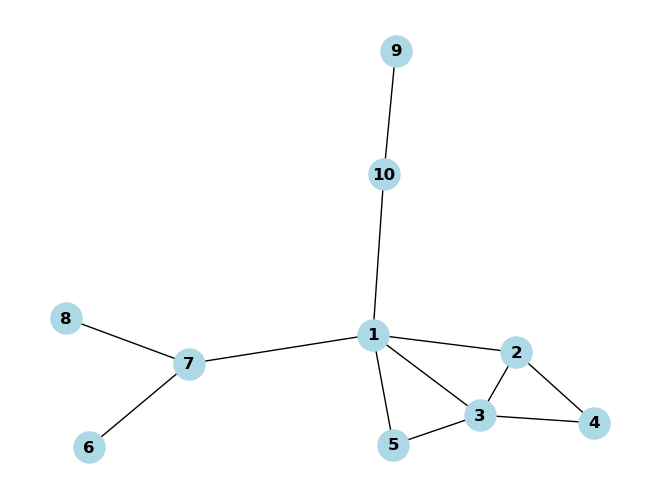

In [5]:
visualize_graph(edge_connections)

In [6]:
def check_condition(node1, node2, node3, path):
    if node1 in path and node2 in path and node3 not in path:
        return False
    elif node3 in path:
        return "Done"
    else:
      return True


In [7]:
def dfs(node: int, visited: List[bool], path: List[int], all_paths: List[List[int]], restrictions_local:  List[List[int]], depth: int):
        visited[node-1] = True
        path.append(node)

        sum_locked = 0
        len_start = len(restrictions_local)
        for restrict in restrictions_local:
          check_result =  check_condition(restrict[0], restrict[1], restrict[2], path)
          if not check_result:
            #print(f" decline {restrict[0], restrict[1], restrict[2], path}")
            sum_locked += 1
          elif check_result == "Done":
           # print(f"Done {restrict[0], restrict[1], restrict[2]}")
            #print(len(restrictions_local))
            restrictions_local.remove(restrict)

        if sum_locked:
            all_paths.append(path[:])
            #print(f"solved: {path}")
            path.pop()
            visited[node-1] = False
            return "Error"


        if path[-4:-2] == path[-2:]:
          #print(f'declined path {path}')
          path.pop()
          visited[node-1] = False
          return None

        if all(visited):
            #print(visited)
            all_paths.append(path[:])
            #print(f"solved: {path}")
            path.pop()
            visited[node-1] = False
            return "Done"

        elif depth >= 10 :
            path.pop()
            #print(depth)
            visited[node-1] = False
            return "Max"

        else:
          for neighbor in edge_connections[node]:
                result = dfs(neighbor, visited.copy(), path, all_paths, restrictions_local.copy(),depth+1)

        visited[node-1] = False
        path.pop()


In [8]:
def find_all_paths(edge_connections: dict, restrictions: List[List[int]]) -> List[List[int]]:
    """
    Given a dictionary of edge connections, return a list of all available paths for traversing
    the graph with repetitions, starting and ending at any node, and visiting all nodes.
    """
    all_nodes = list(edge_connections.keys())
    all_paths = []
    for start_node in tqdm(all_nodes):
        #print(f"start {start_node}")
        visited = [False] * len(all_nodes)
        path = []
        dfs(start_node, visited, path, all_paths, restrictions.copy(), 1)

    return all_paths


In [9]:
def clean_list(all_path, final_name):
  finall_results = {}
  final = []
  for path in all_path:
    name = ','.join(str(x) for x in np.unique(path))
    name = str(np.unique(path))
    # print(len(path))
    if name in finall_results.keys():
      if len(path) < len(finall_results[name]):
        finall_results[name] = path
    elif name == final_name:
      final.append(path)
    else:
      finall_results[name] = path
  print(final)
  if final:
    finall_results[final_name] = final
  return finall_results



In [10]:
all_paths = find_all_paths(edge_connections, restrictions)
final_name = ','.join(str(x) for x in edge_connections)
clean_paths = clean_list(all_paths,final_name)

100%|██████████| 10/10 [00:00<00:00, 10029.42it/s]

[]


In [11]:
import pandas as pd
df = pd.DataFrame(np.zeros((1,4)), 
                      columns= ["start","end","body","connections"] )
df = df.astype({"start" :int,"end" : int, "body" : object,"connections" : object})

for i,r1 in enumerate(clean_paths.values()):
    df.at[i,"start"] = r1[0]
    df.at[i,"end"] = r1[-1]
    df.at[i,"body"] = r1
    df.at[i,"connections"] = []
    df.at[i,"unique"] = len(pd.unique(r1))

for node in edge_connections:
    started = df[df["start"] == node].index
    _ = df[df["end"].isin(edge_connections[node])]["connections"].apply(lambda x: x.extend(started))

df = df.astype({"start" :int,"end" : int, "body" : object,"connections" : object, "unique" :int})


C:\Users\Sundrax\AppData\Local\Temp\ipykernel_20244\893908045.py:11: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  df.at[i,"unique"] = len(pd.unique(r1))
C:\Users\Sundrax\AppData\Local\Temp\ipykernel_20244\893908045.py:11: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  df.at[i,"unique"] = len(pd.unique(r1))
C:\Users\Sundrax\AppData\Local\Temp\ipykernel_20244\893908045.py:11: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  df.at[i,"unique"] = len(pd.unique(r1))
C:\Users\Sundrax\AppData\Local\Temp\ipykernel_20244\893908045.py:11: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  df.

In [12]:
def greedy_cover(stations: dict):
    """
    Используйте жадный алгоритм для решения установленной проблемы покрытия: выберите наименее вещательную станцию, чтобы все области могли принимать сигнал
    :param stations:
    :return:
    """

    # Создайте набор для хранения областей, которые должны быть покрыты, но еще не покрыты
    not_cover = set()
    for v in stations.values():
        for s in v:
            not_cover.add(s)
    unique_num = len(not_cover)
    selects = []  # Сохранить нашу выбранную станцию
    while True:
        # Сначала выберите станцию, которая покрывает наиболее непокрытую территорию
        max_key = ''
        max_num = 0
        for k in stations.keys():
            intersection = not_cover.intersection(stations[k])
            if len(intersection) > max_num:
                max_key = k
                max_num = len(intersection)
        selects.append(max_key)
        # Затем удалите зону покрытия выбранной радиостанции из not_cover
        for e in stations[max_key]:
            if e in not_cover:
                not_cover.remove(e)
        # Если not_cover не пусто, то есть покрыты все области, можно завершить алгоритм
        if len(not_cover) == 0:
            break

    if len(not_cover) !=0:
        return False
    return selects,unique_num



In [13]:
def check_condition_order(node1, node2, node3, path):
    if node1 in path and node2 in path and node3 in path:
      idx1 = np.where(path == node1)[0][0]
      idx2 = np.where(path == node2)[0][0]
      idx3 = np.where(path == node3)[0][0]
      if idx3 > idx1 and idx3 > idx2:
        return False
      else:
        return True
    else:
      return True


In [14]:
def check_condition_order_with__full_return(node1, node2, node3, path):
    if node1 in path and node2 in path and node3 in path:
      idx1 = np.where(path == node1)[0][0]
      idx2 = np.where(path == node2)[0][0]
      idx3 = np.where(path == node3)[0][0]
      if idx3 > idx1 and idx3 > idx2:
        return [node1,node2,node3]
      else:
        return 0
    else:
      return 0
    
def check_condition_order_with_return(node1, node2, node3, path):
    if node1 in path and node2 in path and node3 in path:
      idx1 = np.where(path == node1)[0][0]
      idx2 = np.where(path == node2)[0][0]
      idx3 = np.where(path == node3)[0][0]
      if idx3 > idx1 and idx3 > idx2:
        return node3
      else:
        return 0
    else:
      return 0
    
def check_if_possible(path):
    _,counts = np.unique(path,return_counts=True) 
    a = [check_condition_order_with_return(rest[0],rest[1],rest[2],np.array(path)) for rest in restrictions]
    for i in a:
        if i != None:
            if counts[i-1] == 1:
                #print(f"canceled due to {i}")
                return False
    return True

def can_be_connected(operations,order):
    oper = operations.copy()
    o = 0
    operation_parts = [[] for n in oper]
    for n in order:
        
        if n in oper[0]:
            #print(o)
            #print(f"{n} {o}")
            operation_parts[o].append(n)
            pass
        elif n in oper[1]:
            #print("++")
            #print(f"{oper} and {n}")
            oper = oper[1:]
            o+=1
            #print(f"{n} {o}")
            operation_parts[o].append(n)
        else:
            oper = oper[1:]

   # print(operation_parts)
    for operation, next_operation in zip(operation_parts,operation_parts[1:]):
        if operation:
            connected = False
            #print(operation)
            if operation[0] in next_operation:
                connected = True
            for one, next in zip(operation,operation[1:]):
                if not next in edge_connections[one]:
                    return False # false if not connected inside one operation
                if not connected and (one in next_operation):
                    connected = True


            if not connected:
               # print(next_operation)
                if next_operation and not next_operation[0] in edge_connections[operation[-1]] :
                    return False # False if not connected between operations
    

    return True

def final_rest_check_and_connections(operations,new1):
  
  if not can_be_connected(operations, np.delete(new1, new1==0)):
        print(f"cant be connected {operations} and {np.delete(new1, new1==0)}") 
        return False
  
  if not all((check_condition_order(rest[0],rest[1],rest[2],new1) for rest in restrictions)):
        print(f"{operations} restrictions hit hard")
        return False

  return  True 

# 6 7 1 8 2 9 10 3 4  5

In [ ]:
import itertools as it
from collections import Counter
results = greedy_cover(df.sample(frac=0.1).to_dict("dict")["body"])
uniques = len(edge_connections)
body_part = 1


solutions = pd.DataFrame(np.zeros((1,4)), 
                      columns= ["id","operations","order","full"] )
solutions = solutions.astype({ "id":int,"operations" : object,"order" : object,"full":object})
df_rows_counter = 0
bar = tqdm(range(10000))

id_checked = Counter()
skipped_count = 0
check_count = 0
append_count = 0
frac_dynamic = 0.5
while (len(solutions) < 2):
    skipped_count_local = 0
    check_count_local = 0
    bar = tqdm(range(10000))
    for iter_i in bar:
        result,unique_num = greedy_cover(df.sample(frac=frac_dynamic).to_dict("dict")["body"])
        if not result or unique_num!=10:
            continue
        for var in it.permutations(result):
            if not id_checked[var]:
                id_checked[var] = True
                    #print(f"finded {var} in {res}")
                check_count+=1
                check_count_local+=1
            else:
                    #print(f"skipped {var}")
                skipped_count+=1
                skipped_count_local+=1
                continue
            result_path = np.concatenate(list(df.iloc[list(var)]["body"]))
            for_output = df.iloc[list(var)]["body"].values
        
            if check_if_possible(result_path):
                coun = append_count
                problems = []
                for rest in restrictions:
                    if check_condition_order_with__full_return(rest[0],rest[1],rest[2],result_path):
                        problems.extend(check_condition_order_with__full_return(rest[0],rest[1],rest[2],result_path))

                er = np.unique(problems)

                problems = []
                for i in er:
                    problems.append(list(np.where(result_path==i)[0]))


                import itertools

                new = result_path.copy()
                for i in er:
                    new[np.where(result_path == i)] = 0

                for arr in itertools.product(*problems):
                    new1 = new.copy()
                    for pos,value in zip(arr,er):
                        new1[pos] = value
                        
                    if final_rest_check_and_connections(for_output,new1):
                        print(f"Решение найдено. Из обхода {[list(pd.unique(one)) for one in pd.Series(for_output)]} подходит путь {np.delete(new1, new1==0)}")
                        solutions.loc[len(solutions.index)+1] = [coun,[list(pd.unique(one)) for one in pd.Series(for_output)], np.delete(new1, new1==0), result_path]
                        append_count+=1
                        break
        bar.set_description(f"Checked chains {check_count}, Skipped {skipped_count}, append {append_count}")
    if check_count_local and skipped_count_local/check_count_local > 0.1:
        frac_dynamic = frac_dynamic/2
        print(f"frac_dynamic = {frac_dynamic}\n")
    print(f"\n {check_count}")

# 6 7 1 8 2 9 10 3 4  5

In [42]:
new1

array([ 0,  4,  3,  9, 10,  0,  5,  6,  0,  0, 10,  7,  8,  9, 10,  1,  2])

In [40]:
can_be_connected([[6, 7, 1, 7, 8, 7, 1, 2],[9, 10, 1, 3],[4, 2, 1, 5]],np.array([6, 7, 1,7, 8,7,1, 2,9, 10,1, 3, 4,2,1, 5]))

[[np.int64(6), np.int64(7), np.int64(1), np.int64(7), np.int64(8), np.int64(7), np.int64(1), np.int64(2)], [np.int64(9), np.int64(10), np.int64(1), np.int64(3)], [np.int64(4), np.int64(2), np.int64(1), np.int64(5)]]
[[np.int64(6), np.int64(7), np.int64(1), np.int64(7), np.int64(8), np.int64(7), np.int64(1), np.int64(2)], [np.int64(9), np.int64(10), np.int64(1), np.int64(3)], [np.int64(4), np.int64(2), np.int64(1), np.int64(5)]]
[[np.int64(6), np.int64(7), np.int64(1), np.int64(7), np.int64(8), np.int64(7), np.int64(1), np.int64(2)], [np.int64(9), np.int64(10), np.int64(1), np.int64(3)], [np.int64(4), np.int64(2), np.int64(1), np.int64(5)]]


True

In [31]:
edge_connections

{1: [2, 3, 5, 7, 10],
 2: [1, 3, 4],
 3: [1, 2, 4, 5],
 4: [2, 3],
 5: [1, 3],
 6: [7],
 7: [1, 6, 8],
 8: [7],
 9: [10],
 10: [1, 9]}

In [41]:
def can_be_connected(operations,order):
    oper = operations.copy()
    o = 0
    operation_parts = [[] for n in oper]
    for n in order:
        
        if n in oper[0]:
            #print(o)
            #print(f"{n} {o}")
            operation_parts[o].append(n)
            pass
        elif n in oper[1]:
            #print("++")
            #print(f"{oper} and {n}")
            oper = oper[1:]
            o+=1
            #print(f"{n} {o}")
            operation_parts[o].append(n)
        else:
            oper = oper[1:]

    print(operation_parts)
    for operation, next_operation in zip(operation_parts,operation_parts[1:]):
        if operation:
            connected = False
            print(operation_parts)
            if operation[0] in next_operation:
                connected = True
            for one, next in zip(operation,operation[1:]):
                if not next in edge_connections[one]:
                    # print(f"not connected{one} {next}")
                    return False # false if not connected inside one operation
                if not connected and (one in next_operation):
                    connected = True


            if not connected:
               # print(next_operation)
                if next_operation and not next_operation[0] in edge_connections[operation[-1]] :
                    return False # False if not connected between operations
    

    return True

In [17]:
df

,start,end,body,connections,unique
0,1,2,"[1, 2]","[0, 1, 2, 3, 4, 11, 12, 6, 7, 8, 9]",2
1,1,3,"[1, 3]","[0, 1, 2, 3, 4, 5, 10, 6, 7, 8, 9]",2
2,1,5,"[1, 5]","[0, 1, 2, 3, 4, 11, 12]",2
3,1,7,"[1, 7]","[0, 1, 2, 3, 4, 13, 14, 15, 16, 17, 18, 19, 20...",2
4,1,10,"[1, 10]","[0, 1, 2, 3, 4, 23, 24, 25, 26]",2
5,2,3,"[2, 3]","[0, 1, 2, 3, 4, 5, 10, 6, 7, 8, 9]",2
6,4,3,"[4, 2, 1, 3]","[0, 1, 2, 3, 4, 5, 10, 6, 7, 8, 9]",4
7,4,5,"[4, 2, 1, 5]","[0, 1, 2, 3, 4, 11, 12]",4
8,4,7,"[4, 2, 1, 7]","[0, 1, 2, 3, 4, 13, 14, 15, 16, 17, 18, 19, 20...",4
9,4,10,"[4, 2, 1, 10]","[0, 1, 2, 3, 4, 23, 24, 25, 26]",4


In [26]:
problems

[[np.int64(2), np.int64(6), np.int64(10), np.int64(14), np.int64(18)],
 [np.int64(7)],
 [np.int64(13), np.int64(15), np.int64(17)],
 [np.int64(4), np.int64(8)],
 [np.int64(3), np.int64(5), np.int64(9), np.int64(19)]]

True

In [134]:
result_path

array([14,  9, 15,  9, 11, 12, 10,  2,  3,  4,  2,  1,  5,  1,  6,  8,  2,
        3,  4,  2,  1,  6, 17,  6,  2, 10,  9, 16, 17,  6,  1,  7,  5])

In [133]:
check_if_possible(result_path)

IndexError: index 16 is out of bounds for axis 0 with size 16

In [113]:
pd.Series(for_output)

0      [3, 2, 6, 17, 6, 8, 6, 2, 10]
1    [11, 9, 14, 9, 15, 9, 16, 9, 2]
2              [2, 1, 5, 7, 1, 2, 3]
3                [15, 9, 11, 12, 13]
4          [2, 3, 4, 2, 1, 6, 2, 10]
dtype: object

In [107]:
set(solutions.iloc[2]["order"])

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}

In [110]:
solutions.iloc[10]["order"]

array([17,  7,  5,  2,  3,  4,  6, 17,  1,  8, 14,  9, 15, 16, 10, 14, 15,
       11, 12, 13])

In [117]:
solutions.iloc[10]

id                                                            9
operations    [[2, 3, 4, 1, 7, 9], [17, 6, 1, 7, 5], [12, 11...
order         [2, 3, 4, 1, 7, 1, 17, 6, 1, 7, 5, 12, 11, 15,...
full          [2, 3, 4, 2, 1, 7, 1, 2, 9, 17, 6, 1, 7, 5, 12...
Name: 11, dtype: object

In [ ]:
import itertools as it
from collections import Counter
import time
results = greedy_cover(df.sample(frac=1).to_dict("dict")["body"], depth = 0)
uniques = len(edge_connections)
operations_count = len(results[0])
body_part = 2
id_checked = []

solutions = pd.DataFrame(np.zeros((1,4)), 
                      columns= ["id","operations","order","full"] )
solutions = solutions.astype({ "id":int,"operations" : object,"order" : object,"full":object})
df_rows_counter = 0
start = time.time()  
operation_time = (300/1000)
bar = tqdm(range(100))
skipped_count = 0
check_count = 0
append_count = 0

for iter_i in bar:
    results = greedy_cover(df.sample(frac=1).to_dict("dict")["body"], depth = 0)
    #print("cover done")
    for r in results:
        result_path = np.concatenate(list(df.iloc[list(r)]["body"]))
        for_output = df.iloc[list(r)]["body"].values
        if not any([np.array_equal(result_path,i) for i in id_checked]):
            id_checked.append(result_path)
            #print(f"finded {res}")
            check_count+=1
        else:
            #print(f"skipped {res}")
            skipped_count+=1
            continue

        if check_if_possible(result_path):
            coun = append_count
            problems = []
            for rest in restrictions:
                if check_condition_order_with__full_return(rest[0],rest[1],rest[2],result_path):
                    problems.extend(check_condition_order_with__full_return(rest[0],rest[1],rest[2],result_path))

            er = np.unique(problems)

            problems = []
            for i in er:
                problems.append(list(np.where(result_path==i)[0]))


            import itertools

            new = result_path.copy()
            for i in er:
                new[np.where(result_path == i)] = 0

            for arr in itertools.product(*problems):
                new1 = new.copy()
                for pos,value in zip(arr,er):
                    new1[pos] = value
                    
                if all((check_condition_order(rest[0],rest[1],rest[2],new1) for rest in restrictions)):
                    #print(f"Решение найдено. Из обхода {[list(pd.unique(one)) for one in for_output]} подходит путь {np.delete(new1, new1==0)}")
                    solutions.loc[len(solutions.index)+1] = [coun,[list(pd.unique(one)) for one in for_output], np.delete(new1, new1==0), result_path]
                    append_count+=1
    bar.set_description(f"Checked chains {check_count}, Skipped {skipped_count}, append {append_count}")

In [87]:
Counter(result_path)

Counter({2: 4,
         6: 4,
         9: 3,
         11: 2,
         12: 2,
         3: 2,
         8: 2,
         10: 2,
         1: 2,
         13: 1,
         17: 1,
         14: 1,
         15: 1,
         16: 1,
         4: 1,
         5: 1,
         7: 1})

In [88]:
result_path

array([11, 12, 13,  3,  2,  6, 17,  6,  8,  6,  2, 10, 14,  9, 15,  9, 16,
        9, 11, 12, 10,  2,  3,  4,  2,  1,  5,  7,  1,  6,  8])

In [85]:
for i in it.combinations(result_path,uniques + 3):
      if (len(set(i)) == uniques) and Counter(i)[2]==3:
            print(i)

(11, 12, 13, 3, 2, 6, 17, 6, 8, 2, 10, 14, 9, 15, 16, 2, 4, 1, 5, 7)
(11, 12, 13, 3, 2, 6, 17, 6, 8, 2, 10, 14, 9, 15, 16, 2, 4, 5, 7, 1)
(11, 12, 13, 3, 2, 6, 17, 6, 8, 2, 10, 14, 9, 15, 16, 4, 2, 1, 5, 7)
(11, 12, 13, 3, 2, 6, 17, 6, 8, 2, 10, 14, 9, 15, 16, 4, 2, 5, 7, 1)
(11, 12, 13, 3, 2, 6, 17, 6, 8, 2, 10, 14, 15, 9, 16, 2, 4, 1, 5, 7)
(11, 12, 13, 3, 2, 6, 17, 6, 8, 2, 10, 14, 15, 9, 16, 2, 4, 5, 7, 1)
(11, 12, 13, 3, 2, 6, 17, 6, 8, 2, 10, 14, 15, 9, 16, 4, 2, 1, 5, 7)
(11, 12, 13, 3, 2, 6, 17, 6, 8, 2, 10, 14, 15, 9, 16, 4, 2, 5, 7, 1)
(11, 12, 13, 3, 2, 6, 17, 6, 8, 2, 10, 14, 15, 16, 9, 2, 4, 1, 5, 7)
(11, 12, 13, 3, 2, 6, 17, 6, 8, 2, 10, 14, 15, 16, 9, 2, 4, 5, 7, 1)
(11, 12, 13, 3, 2, 6, 17, 6, 8, 2, 10, 14, 15, 16, 9, 4, 2, 1, 5, 7)
(11, 12, 13, 3, 2, 6, 17, 6, 8, 2, 10, 14, 15, 16, 9, 4, 2, 5, 7, 1)
(11, 12, 13, 3, 2, 6, 17, 6, 8, 2, 14, 9, 15, 16, 10, 2, 4, 1, 5, 7)
(11, 12, 13, 3, 2, 6, 17, 6, 8, 2, 14, 9, 15, 16, 10, 2, 4, 5, 7, 1)
(11, 12, 13, 3, 2, 6, 17, 6, 8, 2,

In [ ]:
for i in it.combinations(result_path,uniques + operations_count - 1):
                 if (len(set(i)) == uniques) and Counter(i)[body_part]==operations_count:
                     if all((check_condition_order(rest[0],rest[1],rest[2],np.array(i)) for rest in restrictions)):
                         print(f"Решение найдено. Из обхода {[list(pd.unique(one)) for one in for_output]} подходит путь {i}")
                         # solutions.at[df_rows_counter,"operations"] = [list(pd.unique(one)) for one in for_output]
                         # solutions.at[df_rows_counter,"order"] = i
                         solutions.loc[len(solutions.index)+1] = [[list(pd.unique(one)) for one in for_output], i]

In [80]:
len(id_checked)

675800

In [66]:
result

[74, 111, 125, 140, 17, 66, 85]

In [70]:
df.iloc[list(var)]

,start,end,body,connections,unique
85,6,8,"[6, 8]","[12, 20, 21, 22, 23, 24, 30, 37, 39, 25, 26, 85]",2
66,3,1,"[3, 2, 6, 17, 6, 1]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 19,...",5
17,7,9,"[7, 1, 2, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 19,...",4
140,12,13,"[12, 13]","[134, 135, 136, 98, 110, 111, 115, 116, 118, 1...",2
125,14,10,"[14, 9, 15, 9, 16, 9, 10]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 19,...",5
111,12,16,"[12, 11, 9, 15, 9, 16]","[88, 114, 117, 133]",5
74,2,10,"[2, 3, 4, 2, 1, 5, 1, 6, 2, 10]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 19,...",7


In [67]:
for var in it.permutations(result):
    print(var)

(74, 111, 125, 140, 17, 66, 85)
(74, 111, 125, 140, 17, 85, 66)
(74, 111, 125, 140, 66, 17, 85)
(74, 111, 125, 140, 66, 85, 17)
(74, 111, 125, 140, 85, 17, 66)
(74, 111, 125, 140, 85, 66, 17)
(74, 111, 125, 17, 140, 66, 85)
(74, 111, 125, 17, 140, 85, 66)
(74, 111, 125, 17, 66, 140, 85)
(74, 111, 125, 17, 66, 85, 140)
(74, 111, 125, 17, 85, 140, 66)
(74, 111, 125, 17, 85, 66, 140)
(74, 111, 125, 66, 140, 17, 85)
(74, 111, 125, 66, 140, 85, 17)
(74, 111, 125, 66, 17, 140, 85)
(74, 111, 125, 66, 17, 85, 140)
(74, 111, 125, 66, 85, 140, 17)
(74, 111, 125, 66, 85, 17, 140)
(74, 111, 125, 85, 140, 17, 66)
(74, 111, 125, 85, 140, 66, 17)
(74, 111, 125, 85, 17, 140, 66)
(74, 111, 125, 85, 17, 66, 140)
(74, 111, 125, 85, 66, 140, 17)
(74, 111, 125, 85, 66, 17, 140)
(74, 111, 140, 125, 17, 66, 85)
(74, 111, 140, 125, 17, 85, 66)
(74, 111, 140, 125, 66, 17, 85)
(74, 111, 140, 125, 66, 85, 17)
(74, 111, 140, 125, 85, 17, 66)
(74, 111, 140, 125, 85, 66, 17)
(74, 111, 140, 17, 125, 66, 85)
(74, 111

In [63]:
len(id_checked)

2248

In [59]:
it.combinations(result_path,uniques)

NameError: name 'result_path' is not defined

In [15]:
df

,start,end,body,connections,unique
0,2,6,"[2, 1, 5, 1, 6]","[12, 20, 21, 22, 23, 24, 30, 37, 39, 0, 1, 2, ...",4
1,2,8,"[2, 1, 5, 1, 8]","[12, 20, 21, 22, 23, 24, 30, 37, 39, 25, 26, 85]",4
2,2,6,"[2, 1, 5, 7, 1, 6]","[12, 20, 21, 22, 23, 24, 30, 37, 39, 0, 1, 2, ...",5
3,2,8,"[2, 1, 5, 7, 1, 8]","[12, 20, 21, 22, 23, 24, 30, 37, 39, 25, 26, 85]",5
4,2,3,"[2, 1, 5, 1, 2, 3]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 19,...",4
...,...,...,...,...,...
136,10,13,"[10, 13]","[134, 135, 136, 98, 110, 111, 115, 116, 118, 1...",2
137,11,10,"[11, 12, 10]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 19,...",3
138,11,13,"[11, 12, 13]","[134, 135, 136, 98, 110, 111, 115, 116, 118, 1...",3
139,12,2,"[12, 11, 9, 14, 9, 15, 9, 16, 9, 2]","[12, 20, 21, 22, 23, 24, 30, 37, 39, 62, 63, 6...",7
